# Mixture Models


Notebook to play around with the Iris dataset and Mixture Models


In [1]:
%load_ext nb_black
import seaborn as sns
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<IPython.core.display.Javascript object>

In [2]:
iris_df = sns.load_dataset("iris")
iris_df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


<IPython.core.display.Javascript object>

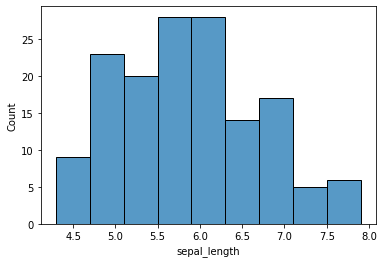

<IPython.core.display.Javascript object>

In [3]:
_ = sns.histplot(iris_df.sepal_length)

In [4]:
with pm.Model() as model_1:
    # priors
    setosa_mu = pm.Normal("setosa_mu", 6, 2)
    virginica_mu = pm.Normal("virginica_mu", 6, 2)
    setosa_sigma = pm.HalfNormal("setosa_sigma", 1)
    virginica_sigma = pm.HalfNormal("virginica_sigma", 1)

    # likelihoods
    y_setosa = pm.Normal(
        "y_setosa",
        mu=setosa_mu,
        sigma=setosa_sigma,
        observed=iris_df[iris_df.species == "setosa"].sepal_length,
    )
    y_virginica = pm.Normal(
        "y_virginica",
        mu=virginica_mu,
        sigma=virginica_sigma,
        observed=iris_df[iris_df.species == "virginica"].sepal_length,
    )

    # difference

    sepal_length_delta = pm.Deterministic(
        "sepal_length_delta", setosa_mu - virginica_mu
    )

    trace_1 = pm.sample(1000)

<ipython-input-4-9407184e70f2>:28: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_1 = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [virginica_sigma, setosa_sigma, virginica_mu, setosa_mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


<IPython.core.display.Javascript object>

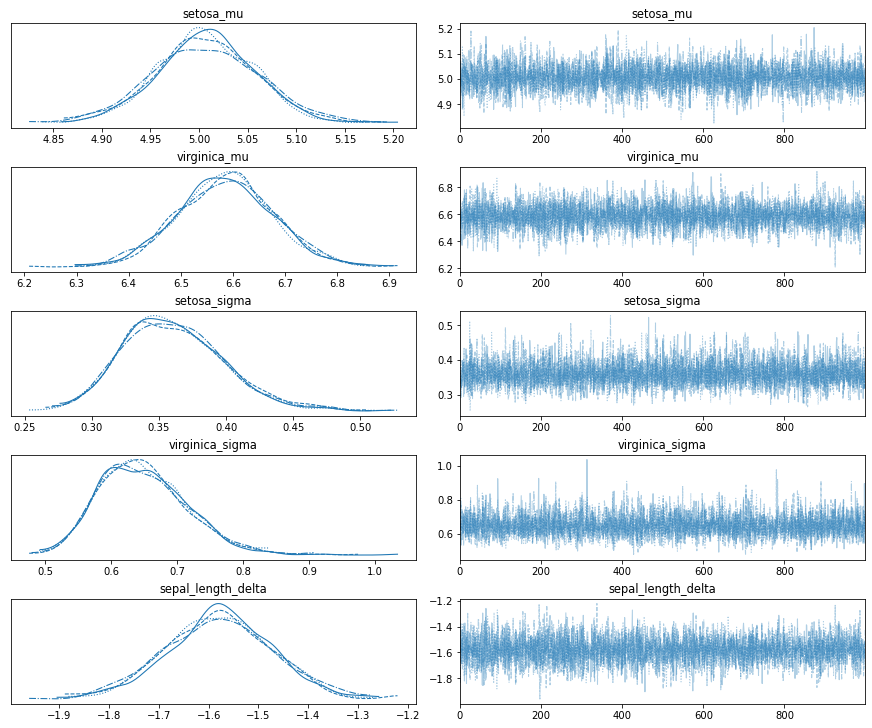

<IPython.core.display.Javascript object>

In [5]:
with model_1:
    pm.plot_trace(trace_1)

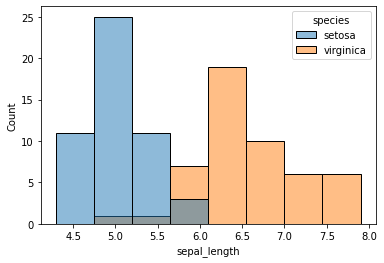

<IPython.core.display.Javascript object>

In [6]:
_ = sns.histplot(
    data=iris_df[iris_df.species.isin(["setosa", "virginica"])],
    x="sepal_length",
    hue="species",
)

In this exercise the species labels from the iris dataset were used to the get mean value for the sepal length for two of the three species included. However, with all this information at hand other, traditional, stats could have been used as well. Where it get's interesting is if we don't know which species the samples belong to. This occurs more frequently than you might think of in Biology or Ecology !


## Lets assume we don't have knowledge about the species !

Typically when doing this type of analysis you don't know which measurement belongs to which species. Sometimes you might not even know how many species are in the mix. However, let's keep it simple and use the knowledge we have that here are three species (but not which measurements belong to which species). To follow the first example of the book along, we'll also need the means of each species along with the standard deviation ... That is fine for now, but hopefully we can forgo these at one point.


In [7]:
iris_df.groupby(["species"]).agg(
    mean_sepal_length=pd.NamedAgg(column="sepal_length", aggfunc="mean"),
    std_sepal_length=pd.NamedAgg(column="sepal_length", aggfunc="std"),
    mean_petal_length=pd.NamedAgg(column="petal_length", aggfunc="mean"),
    std_petal_length=pd.NamedAgg(column="petal_length", aggfunc="std"),
    mean_sepal_width=pd.NamedAgg(column="sepal_width", aggfunc="mean"),
    std_sepal_width=pd.NamedAgg(column="sepal_width", aggfunc="std"),
    mean_petal_width=pd.NamedAgg(column="petal_width", aggfunc="mean"),
    std_petal_width=pd.NamedAgg(column="petal_width", aggfunc="std"),
)

,mean_sepal_length,std_sepal_length,mean_petal_length,std_petal_length,mean_sepal_width,std_sepal_width,mean_petal_width,std_petal_width
species,,,,,,,,
setosa,5.006,0.352490,1.462,0.173664,3.428,0.379064,0.246,0.105386
versicolor,5.936,0.516171,4.260,0.469911,2.770,0.313798,1.326,0.197753
virginica,6.588,0.635880,5.552,0.551895,2.974,0.322497,2.026,0.274650


<IPython.core.display.Javascript object>

In [8]:
n_clusters = 3
n_observations = len(iris_df.sepal_length)
with pm.Model() as model_2:
    p = pm.Dirichlet("p", a=np.ones(n_clusters))
    category = pm.Categorical("category", p=p, shape=n_observations)
    means = pm.math.constant([5.0006, 5.936, 6.588])
    y = pm.Normal("y", mu=means[category], sd=0.5, observed=iris_df.sepal_length)

    step1 = pm.CategoricalGibbsMetropolis(vars=[category])
    step2 = pm.Metropolis(vars=[p])
    trace_2 = pm.sample(10000, step=[step1, step2])

<ipython-input-8-840512bafe48>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_2 = pm.sample(10000, step=[step1, step2])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [category]
>Metropolis: [p]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 147 seconds.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>

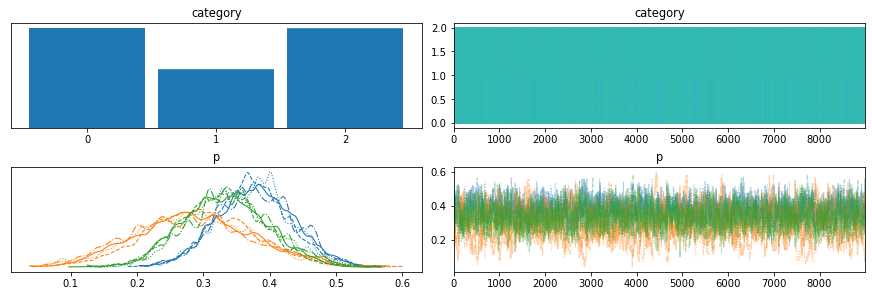

<IPython.core.display.Javascript object>

In [9]:
with model_2:
    pm.plot_trace(trace_2[1000:])

So what this tells us is the frequency of all categories. Given that the iris dataset is perfectly balanced accross the three species (50 samples each) that indeed should be around 0.33.. for all of the categories. The next step is to also estimate the means and standard deviation from the data. So let's make the model more complex.

In [10]:
n_clusters = 3
n_observations = len(iris_df.sepal_length)
with pm.Model() as model_3:
    p = pm.Dirichlet("p", a=np.ones(n_clusters))
    sigma = pm.HalfNormal("sigma", sigma=1)

    means = pm.Normal("means", [5.5, 6, 6.5], sd=0.5, shape=n_clusters)

    # Likelihood, here a normalmixture is used as this is preferred over implementing this yourself in the model (as done in the previous)
    y = pm.NormalMixture("y", w=p, mu=means, sd=sigma, observed=iris_df.sepal_length)

    step = pm.Metropolis()
    trace_3 = pm.sample(20000, step)

<ipython-input-10-b3247c195a34>:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_3 = pm.sample(20000, step)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [means]
>Metropolis: [sigma]
>Metropolis: [p]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 38 seconds.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>

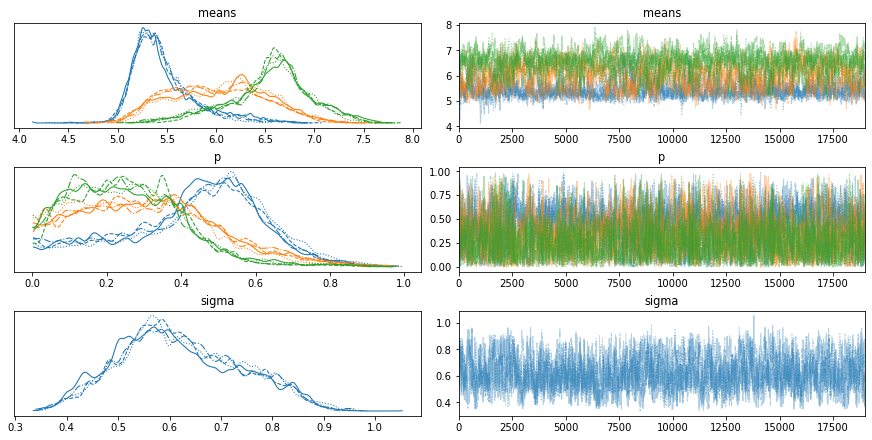

<IPython.core.display.Javascript object>

In [11]:
with model_3:
    pm.plot_trace(trace_3[1000:])

In [12]:
with model_3:
    display(az.summary(trace_3[1000:], round_to=2, var_names=["means", "p", "sigma"]))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],5.46,0.32,4.98,6.11,0.01,0.01,568.73,476.50,1.01
means[1],6.03,0.48,5.16,6.86,0.03,0.02,269.02,791.25,1.01
means[2],6.54,0.42,5.66,7.29,0.02,0.01,496.64,918.21,1.01
p[0],0.43,0.19,0.00,0.70,0.01,0.01,760.39,1155.93,1.00
p[1],0.31,0.19,0.00,0.63,0.01,0.00,818.04,1676.06,1.01
p[2],0.26,0.15,0.00,0.50,0.00,0.00,1023.65,1992.10,1.00
sigma,0.62,0.12,0.42,0.85,0.00,0.00,615.16,1466.24,1.00


<IPython.core.display.Javascript object>

We can get a much better fit if we include set values for p manually (see below). This is possible here, though depending on the type of data you are working with this might not be known. E.g. If we are trying to estimate if values are different between men and women and subjects were properly randomized it will be perfectly fine to set this at 0.5 for the two groups. However, in most cases we won't know this.



The book also mentions the NormalMixture is preferred over doing the categories yourself, so this has been implemented in this model as well.

In [13]:
with pm.Model() as model_4:
    p = pm.math.constant([0.33, 0.33, 0.34]) # This line can be used to predefine p for the three groups
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    means = pm.Normal("means", [5, 6, 7], sd=0.5, shape=n_clusters)

    # Likelihood, here a normalmixture is used as this is preferred over implementing this yourself in the model (as done in the previous)
    y = pm.NormalMixture("y", w=p, mu=means, sd=sigma, observed=iris_df.sepal_length)
    
    step = pm.Metropolis()
    trace_4 = pm.sample(20000, step)


<ipython-input-13-39df1315dd5c>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_4 = pm.sample(20000, step)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [means]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 33 seconds.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>

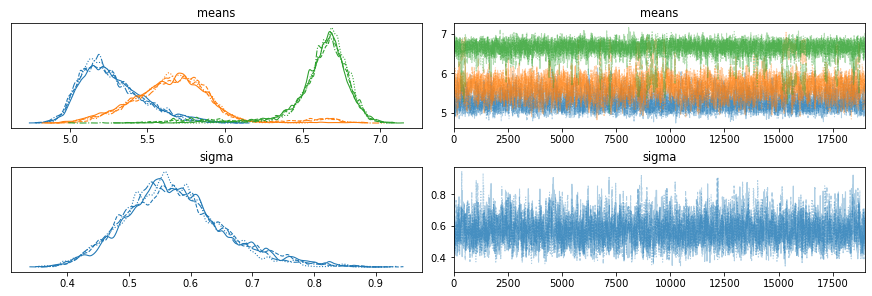

<IPython.core.display.Javascript object>

In [14]:
with model_4:
    pm.plot_trace(trace_4[1000:])

In [15]:
with model_4:
    display(az.summary(trace_4[1000:], round_to=2, var_names=["means"]))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],5.27,0.20,4.94,5.66,0.00,0.00,1721.53,2881.54,1.00
means[1],5.67,0.27,5.12,6.07,0.01,0.01,724.97,322.63,1.01
means[2],6.62,0.21,6.29,6.95,0.01,0.01,1028.43,293.36,1.00


<IPython.core.display.Javascript object>

In [16]:
n_clusters = 3
n_observations = len(iris_df.sepal_length)
with pm.Model() as model_5:
    sl_sigma = pm.HalfNormal("sl_sigma", sigma=1)
    pl_sigma = pm.HalfNormal("pl_sigma", sigma=1)
    sw_sigma = pm.HalfNormal("sw_sigma", sigma=1)
    pw_sigma = pm.HalfNormal("pw_sigma", sigma=1)

    p = pm.Dirichlet("p", a=np.ones(n_clusters))
    category = pm.Categorical("category", p=p, shape=n_observations)

    # We need to set the means of one variable to have a low, middle and high value to make sure the groups are
    # identified in the same order accross chains !
    sl_means = pm.Normal("sl_means", [5, 6, 7], sd=0.5, shape=n_clusters)
    pl_means = pm.Normal("pl_means", [4, 4, 4], sd=1, shape=n_clusters)
    sw_means = pm.Normal("sw_means", [3, 3, 3], sd=1, shape=n_clusters)
    pw_means = pm.Normal("pw_means", [1.5, 1.5, 1.5], sd=1, shape=n_clusters)

    y_sl = pm.Normal(
        "y_sl", mu=sl_means[category], sd=sl_sigma, observed=iris_df.sepal_length
    )
    y_pl = pm.Normal(
        "y_pl", mu=pl_means[category], sd=pl_sigma, observed=iris_df.petal_length
    )
    y_sw = pm.Normal(
        "y_sw", mu=sw_means[category], sd=sw_sigma, observed=iris_df.sepal_width
    )
    y_pw = pm.Normal(
        "y_pw", mu=pw_means[category], sd=pw_sigma, observed=iris_df.petal_width
    )

    trace_5 = pm.sample(10000)

<ipython-input-16-d5299cd8c4f4>:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_5 = pm.sample(10000)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [pw_means, sw_means, pl_means, sl_means, p, pw_sigma, sw_sigma, pl_sigma, sl_sigma]
>CategoricalGibbsMetropolis: [category]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 260 seconds.
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

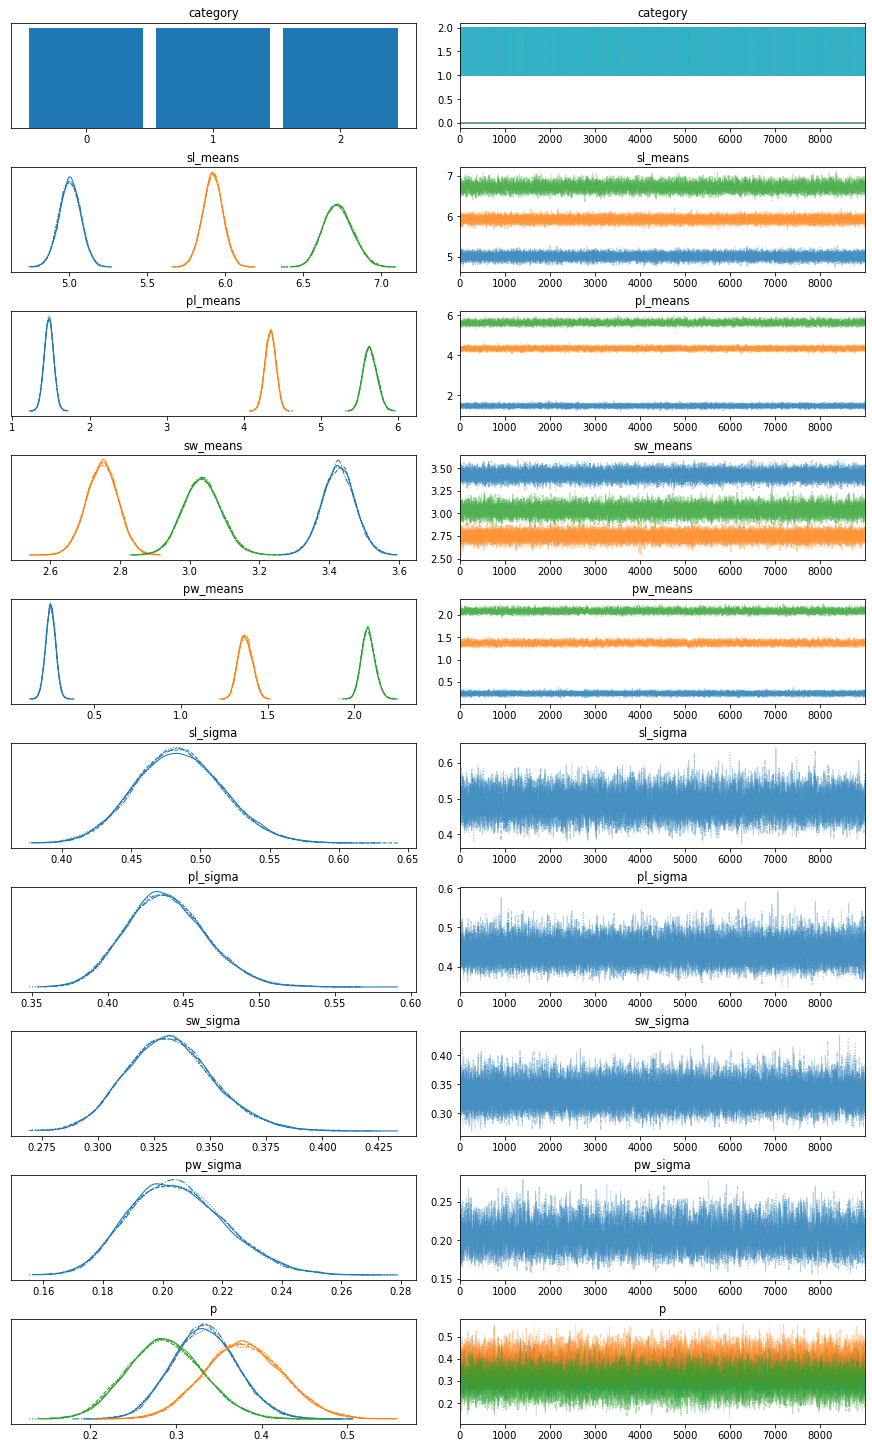

<IPython.core.display.Javascript object>

In [17]:
with model_5:
    pm.plot_trace(trace_5[1000:])

In [18]:
with model_5:
    display(
        az.summary(
            trace_5[1000:],
            round_to=2,
            var_names=["sl_means", "pl_means", "sw_means", "pw_means"],
        )
    )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sl_means[0],5.01,0.07,4.88,5.14,0.0,0.0,57664.54,28045.41,1.0
sl_means[1],5.92,0.07,5.80,6.04,0.0,0.0,42568.59,26252.46,1.0
sl_means[2],6.72,0.09,6.55,6.90,0.0,0.0,5340.16,12475.52,1.0
pl_means[0],1.47,0.06,1.36,1.59,0.0,0.0,57506.09,27850.90,1.0
pl_means[1],4.35,0.07,4.21,4.48,0.0,0.0,6814.49,16895.30,1.0
pl_means[2],5.64,0.09,5.48,5.80,0.0,0.0,4981.34,12446.27,1.0
sw_means[0],3.43,0.05,3.34,3.51,0.0,0.0,57672.51,27052.65,1.0
sw_means[1],2.75,0.05,2.66,2.84,0.0,0.0,43890.29,27372.75,1.0
sw_means[2],3.04,0.05,2.93,3.14,0.0,0.0,13839.79,19953.45,1.0
pw_means[0],0.25,0.03,0.19,0.30,0.0,0.0,57119.98,27690.22,1.0


<IPython.core.display.Javascript object>

Now we have a multple mixture model, though we still need to define the number of clusters beforehand. This is the last hurdle to overcome. To do this we'll have to run the model with a number of different cluster sizes and then pick the one that is the best fit, penalizing models with more clusters.

In [19]:
def make_model_trace(n_clusters, n_observations):
    with pm.Model() as model:
        sl_sigma = pm.HalfNormal("sl_sigma", sigma=1)
        pl_sigma = pm.HalfNormal("pl_sigma", sigma=1)
        sw_sigma = pm.HalfNormal("sw_sigma", sigma=1)
        pw_sigma = pm.HalfNormal("pw_sigma", sigma=1)

        p = pm.Dirichlet("p", a=np.ones(n_clusters))
        category = pm.Categorical("category", p=p, shape=n_observations)

        # We need to set the means of one variable to have a low, middle and high value to make sure the groups are
        # identified in the same order accross chains !
        sl_means = pm.Normal("sl_means", [6] * n_clusters, sd=1, shape=n_clusters)
        pl_means = pm.Normal("pl_means", [4] * n_clusters, sd=1, shape=n_clusters)
        sw_means = pm.Normal("sw_means", [3] * n_clusters, sd=1, shape=n_clusters)
        pw_means = pm.Normal("pw_means", [1.5] * n_clusters, sd=1, shape=n_clusters)

        y_sl = pm.Normal(
            "y_sl", mu=sl_means[category], sd=sl_sigma, observed=iris_df.sepal_length
        )
        y_pl = pm.Normal(
            "y_pl", mu=pl_means[category], sd=pl_sigma, observed=iris_df.petal_length
        )
        y_sw = pm.Normal(
            "y_sw", mu=sw_means[category], sd=sw_sigma, observed=iris_df.sepal_width
        )
        y_pw = pm.Normal(
            "y_pw", mu=pw_means[category], sd=pw_sigma, observed=iris_df.petal_width
        )

        trace = pm.sample(10000)
    return model, trace

<IPython.core.display.Javascript object>

In [20]:
model_c3, trace_c3 = make_model_trace(3, 150)

<ipython-input-19-022fac398aec>:31: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [pw_means, sw_means, pl_means, sl_means, p, pw_sigma, sw_sigma, pl_sigma, sl_sigma]
>CategoricalGibbsMetropolis: [category]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 259 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

In [21]:
model_c2, trace_c2 = make_model_trace(2, 150)

<ipython-input-19-022fac398aec>:31: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [pw_means, sw_means, pl_means, sl_means, p, pw_sigma, sw_sigma, pl_sigma, sl_sigma]
>BinaryGibbsMetropolis: [category]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 191 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

In [22]:
model_c4, trace_c4 = make_model_trace(4, 150)

<ipython-input-19-022fac398aec>:31: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [pw_means, sw_means, pl_means, sl_means, p, pw_sigma, sw_sigma, pl_sigma, sl_sigma]
>CategoricalGibbsMetropolis: [category]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 263 seconds.
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

In [23]:
model_c5, trace_c5 = make_model_trace(5, 150)

<ipython-input-19-022fac398aec>:31: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [pw_means, sw_means, pl_means, sl_means, p, pw_sigma, sw_sigma, pl_sigma, sl_sigma]
>CategoricalGibbsMetropolis: [category]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 264 seconds.
There were 8458 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.020504385619555164, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

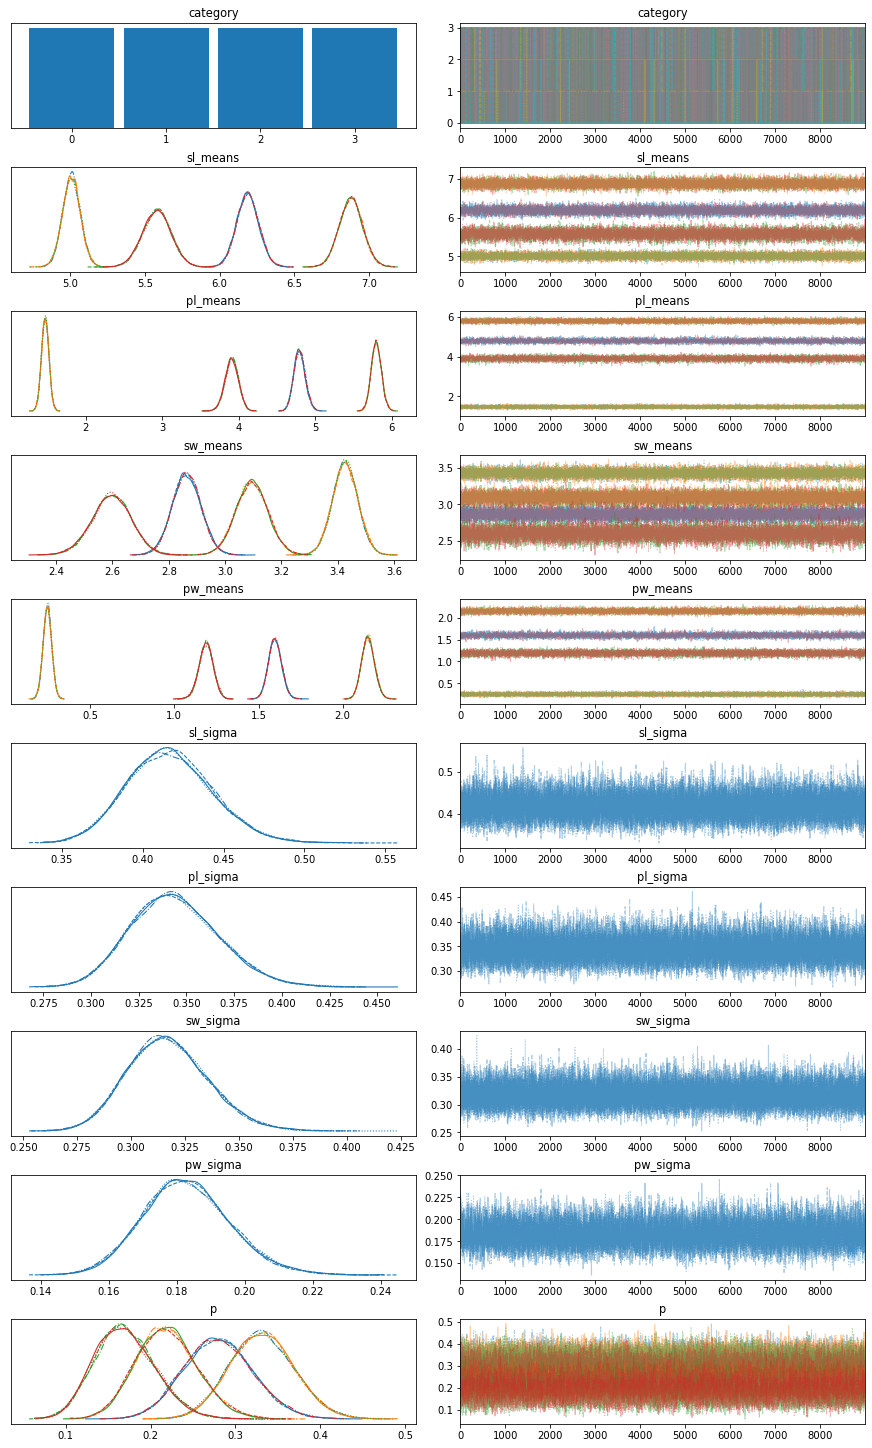

<IPython.core.display.Javascript object>

In [24]:
with model_c4:
    pm.plot_trace(trace_c4[1000:])

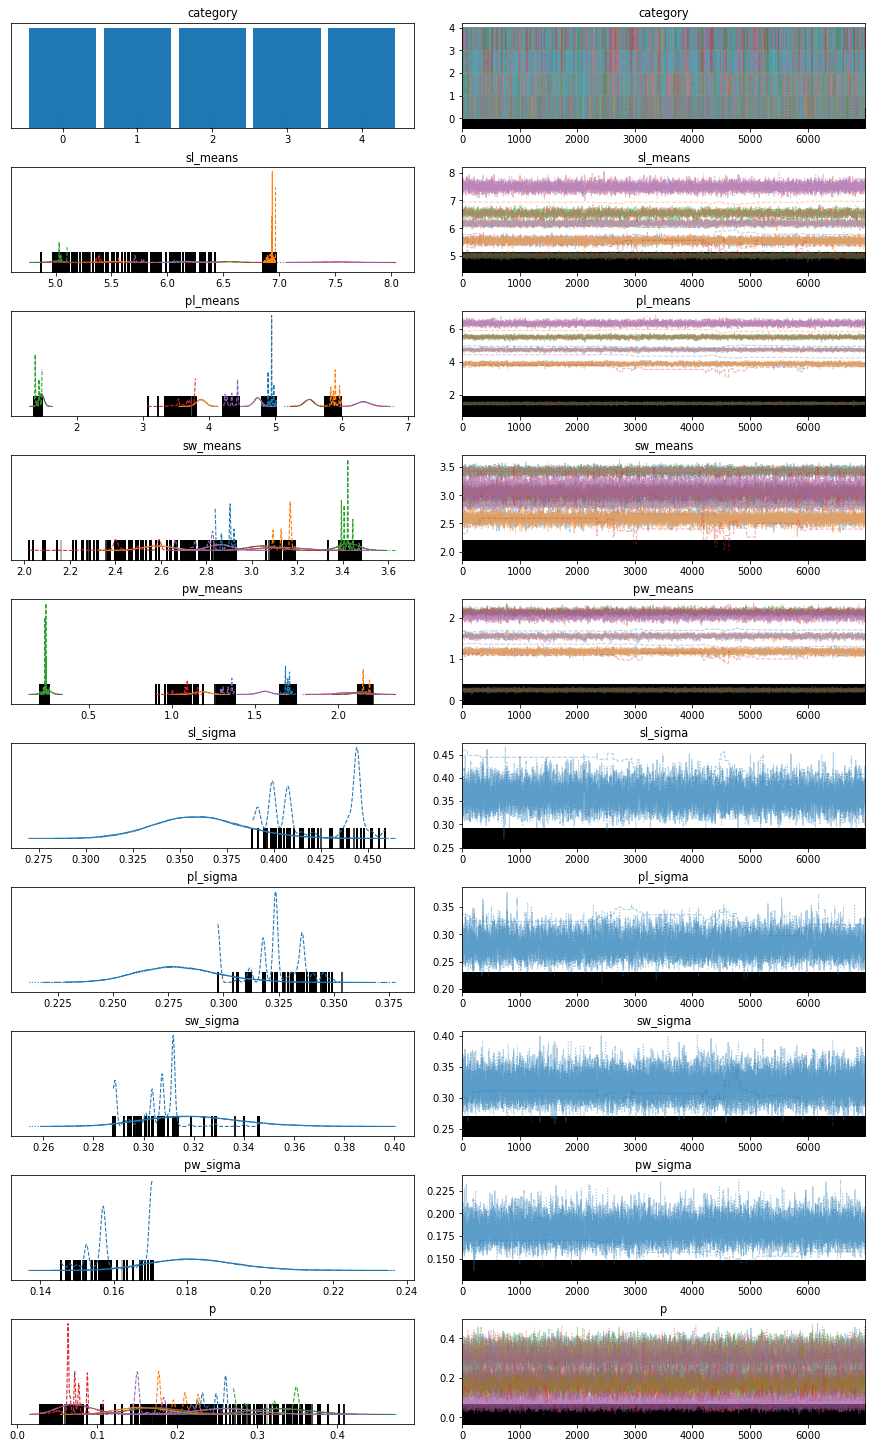

<IPython.core.display.Javascript object>

In [25]:
with model_c5:
    pm.plot_trace(trace_c5[3000:])

In [26]:
dims = {
    "y_sl": ["subject"],
    "y_pl": ["subject"],
    "y_sw": ["subject"],
    "y_pw": ["subject"],
}
with model_c5:
    c5_df = az.from_pymc3(trace_c5[3000:], dims=dims)
with model_c4:
    c4_df = az.from_pymc3(trace_c4[1000:], dims=dims)
with model_c3:
    c3_df = az.from_pymc3(trace_c3[1000:], dims=dims)
with model_c2:
    c2_df = az.from_pymc3(trace_c2[1000:], dims=dims)

0, dim: subject, 150 =? 0
0, dim: subject, 150 =? 0
0, dim: subject, 150 =? 0
0, dim: subject, 150 =? 0
0, dim: subject, 150 =? 0
0, dim: subject, 150 =? 0
0, dim: subject, 150 =? 0
0, dim: subject, 150 =? 0
0, dim: subject, 150 =? 0
0, dim: subject, 150 =? 0
0, dim: subject, 150 =? 0
0, dim: subject, 150 =? 0
0, dim: subject, 150 =? 0
0, dim: subject, 150 =? 0
0, dim: subject, 150 =? 0
0, dim: subject, 150 =? 0


<IPython.core.display.Javascript object>

In [27]:
import xarray as xr

# https://github.com/OriolAbril/calaix_de_sastre/blob/master/arviz_ic_multiple_observations/exp_vs_power_pymc_discourse/pymc3_example.ipynb
print("Leave one *observation* out cross validation (whole model)\n")
condition_dim = xr.DataArray(["sl", "pl", "sw", "pw"], name="condition")
log_lik_c5 = c5_df.log_likelihood
c5_df.sample_stats["log_likelihood"] = xr.concat(
    (log_lik_c5.y_sl, log_lik_c5.y_pl, log_lik_c5.y_sw, log_lik_c5.y_pw),
    dim=condition_dim,
)
log_lik_c4 = c4_df.log_likelihood
c4_df.sample_stats["log_likelihood"] = xr.concat(
    (log_lik_c4.y_sl, log_lik_c4.y_pl, log_lik_c4.y_sw, log_lik_c4.y_pw),
    dim=condition_dim,
)
log_lik_c3 = c3_df.log_likelihood
c3_df.sample_stats["log_likelihood"] = xr.concat(
    (log_lik_c3.y_sl, log_lik_c3.y_pl, log_lik_c3.y_sw, log_lik_c3.y_pw),
    dim=condition_dim,
)
log_lik_c2 = c2_df.log_likelihood
c2_df.sample_stats["log_likelihood"] = xr.concat(
    (log_lik_c2.y_sl, log_lik_c2.y_pl, log_lik_c2.y_sw, log_lik_c2.y_pw),
    dim=condition_dim,
)

comp = az.compare({"c2": c2_df, "c3": c3_df, "c4": c4_df, "c5": c5_df})

Leave one *observation* out cross validation (whole model)



C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\numpy\core\_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with 

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='Log'>

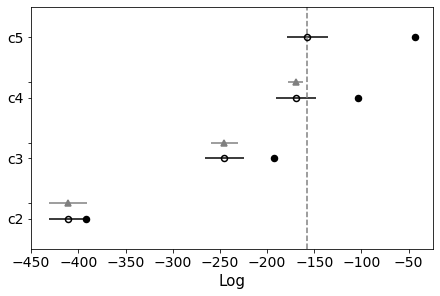

<IPython.core.display.Javascript object>

In [28]:
az.plot_compare(comp)